In [1]:
import sys
from glob import glob

import numpy as np
import h5py
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from matplotlib import lines, colors

from scipy.stats.kde import gaussian_kde
from scipy.signal import savgol_filter

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sys.path.append('/home/paul/Documents/multiviewtracks/MultiViewTracks/')
# download at https://github.com/pnuehrenberg/multiviewtracks and edit path accordingly

from utils import load, save, plot_tracks_2d
from tracks import tracks_to_pooled, tracks_from_pooled

from analysis import *

# Main analysis

In [2]:
# path to tracks, dom id, bottom length of tank in px, video fps
trials = [('../../data/tracks/revised/tracks_T3_revised.pkl', 0, 1102, 25),
          ('../../data/tracks/revised/tracks_T4_revised.pkl', 8, 1095, 25),
          ('../../data/tracks/revised/tracks_T5_revised.pkl', 0, 1106, 25),
          ('../../data/tracks/revised/tracks_T6_revised.pkl', 7, 1109, 25),
          ('../../data/tracks/revised/tracks_T7_revised.pkl', 7, 1087, 25),
          ('../../data/tracks/revised/tracks_T12_revised.pkl', 9, 829, 60)]

# bottom length of tank in m
bottom_length = 0.9652

In [3]:
# colors for dom and sub
dom_color = tuple(v / 255 for v in (255, 109, 69))
sub_color = tuple(v / 255 for v in (39, 170, 214))

# create lists for output, load in case of visual field data
all_data = []
angular_areas = load('../../data/visualfield/angular_areas_all_trials.pkl')
all_time_above = []
all_event_ids = []
dom_idx = []
dom_all_event_times = []
dom_all_event_ids = []
dom_centrality = []
aa_out_dom = []
sub_all_event_times = []
sub_all_event_ids = []
sub_centrality = []
aa_out_sub = []

# loop through all trials and calculate social parameters, networks etc.
for trial_idx in range(len(trials)):
    tracks = load(trials[trial_idx][0])
    dom_id = trials[trial_idx][1]
    tracks, dom_id = enumerate_identities(tracks, dom_id)
    px_p_m = trials[trial_idx][2] / bottom_length
    fps = trials[trial_idx][3]
    dom_idx.append(dom_id)
    speed_distribution = get_speed_distribution(tracks, fps)
    q = np.quantile(speed_distribution, 0.95)
    intervals_above = threshold_speed(tracks, q, fps, dom_id=dom_id, plot=False)
    data = list(get_data(tracks, intervals_above, px_p_m))
    data[2] = angular_areas[trial_idx] # injecting visual field reconstruction data here
    all_event_ids.append(data[-1])
    grouped_data = group_data(tracks, data, dom_id)
    all_data.append(grouped_data)
    dom_all_event_times.append(grouped_data[-2][0])
    sub_all_event_times.append(grouped_data[-2][1])
    dom_all_event_ids.append(grouped_data[-1][0])
    sub_all_event_ids.append(grouped_data[-1][1])

# concatenate for dataframe (separate for dom and sub)
centrality_dom = np.concatenate([all_data[idx][0][0] for idx in range(len(all_data))])
centrality_sub = np.concatenate([all_data[idx][0][1] for idx in range(len(all_data))])
pairwise_dist_dom = np.concatenate([all_data[idx][1][0] for idx in range(len(all_data))])
pairwise_dist_sub = np.concatenate([all_data[idx][1][1] for idx in range(len(all_data))])
aa_out_dom = np.concatenate([all_data[idx][2][0] for idx in range(len(all_data))])
aa_out_sub = np.concatenate([all_data[idx][2][1] for idx in range(len(all_data))])
rel_time_above_dom = np.concatenate([all_data[idx][3][0] for idx in range(len(all_data))])
rel_time_above_sub = np.concatenate([all_data[idx][3][1] for idx in range(len(all_data))])

# concatenate for dataframe with both dom and sub
centrality = np.concatenate([np.array(centrality_sub).ravel(), np.array(centrality_dom).ravel()])
aa_out = np.concatenate([aa_out_sub, aa_out_dom])
pairwise_dist = np.concatenate([np.array(pairwise_dist_sub).ravel(), np.array(pairwise_dist_dom).ravel()])
event_frequency = np.concatenate([np.array(rel_time_above_sub).ravel(), np.array(rel_time_above_dom).ravel()])

# create dataframe
social_parameters = pd.DataFrame.from_dict({'centrality': centrality,
                                            'aa_out': aa_out,
                                            'pairwise_dist': pairwise_dist,
                                            'noise_frequency': event_frequency,
                                            'social_status': ['SUB'] * 54 + ['DOM'] * 6,
                                            'trial': np.repeat(np.arange(6), 9).tolist() + np.arange(6).tolist()})

# social_parameters.to_csv('social_parameters.csv') # export to csv

# standardize parameters for pca and fit pca
scaler = preprocessing.StandardScaler()
for column in social_parameters.columns[:-2]:
    social_parameters[column] = scaler.fit_transform(np.array(social_parameters[column]).reshape(-1, 1)).ravel()
pca = PCA(n_components=len(social_parameters.columns[:-2]))
social_space = pca.fit_transform(np.array(social_parameters.iloc[:, :-2]))

# create delay times dataframe
delay_times = {'delay': np.concatenate([np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times])),
                                        np.concatenate([dom_times for dom_times in dom_all_event_times])]),
               'id': np.concatenate([np.concatenate(np.concatenate([sub_ids for sub_ids in sub_all_event_ids])),
                                        np.concatenate([dom_ids for dom_ids in dom_all_event_ids])]),
               'social_status': ['SUB'] * np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times])).size \
                                 + ['DOM'] * np.concatenate([dom_times for dom_times in dom_all_event_times]).size}
delay_times = pd.DataFrame.from_dict(delay_times)

# delay_times.to_csv('delay_times.csv') # export to csv

# Visualization

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

%matplotlib inline

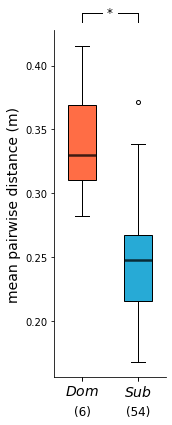

In [5]:
# mean pairwise distance boxplots
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = ax.boxplot([pairwise_dist_dom, pairwise_dist_sub],
                 widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                 medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                 patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(pairwise_dist_dom)),
                    r'$Sub$', '\n''({})'.format(len(pairwise_dist_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.set_ylabel('mean pairwise distance (m)', fontsize=14)

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] + 2 * y_range * bracket_height

for x_values, idx in zip([[1, 1.35], [1.65, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 1, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.show()

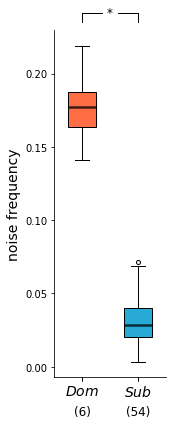

In [6]:
# noise frequency boxplots
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = ax.boxplot([rel_time_above_dom, rel_time_above_sub],
                 widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                 medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                 patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(rel_time_above_dom)),
                    r'$Sub$', '\n''({})'.format(len(rel_time_above_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.set_ylabel('noise frequency', fontsize=14)

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] + 2 * y_range * bracket_height

for x_values, idx in zip([[1, 1.35], [1.65, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 2, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.show()

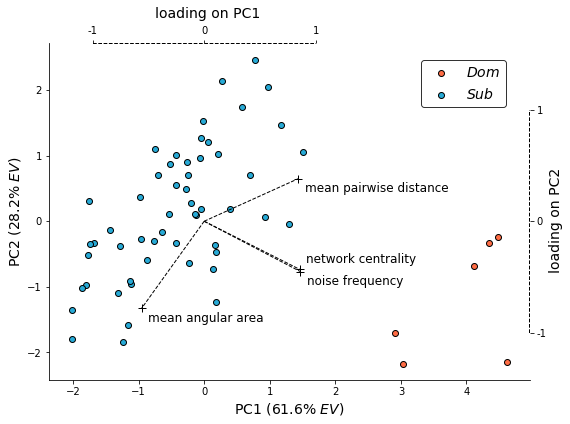

In [7]:
# pca biplot
plt.rcParams['lines.scale_dashes'] = False

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, label=0)
ax_loadings= fig.add_subplot(111, label=1, frame_on=False)

ax.scatter(social_space[social_parameters['social_status'] == 'DOM', 0],
           social_space[social_parameters['social_status'] == 'DOM', 1],
           c=np.array(dom_color).reshape(1, -1), edgecolor='k', label=r'$Dom$')
ax.scatter(social_space[social_parameters['social_status'] == 'SUB', 0],
           social_space[social_parameters['social_status'] == 'SUB', 1],
           c=np.array(sub_color).reshape(1, -1), edgecolor='k', label=r'$Sub$')
ax.set_xlabel(r'PC1 ({:.1f}% $EV$)'.format(pca.explained_variance_ratio_[0] * 100), fontsize=14)
ax.set_ylabel(r'PC2 ({:.1f}% $EV$)'.format(pca.explained_variance_ratio_[1] * 100), fontsize=14)

scale = 1.7
loadings = pca.components_.T * np.sqrt(pca.explained_variance_) * scale
for loading, label in zip(loadings, ['network centrality', 'mean angular area', 'mean pairwise distance', 'noise frequency']):
    ax_loadings.plot([0, loading[0]], [0, loading[1]], 'k--', solid_capstyle='round', lw=1)
    ax_loadings.text(loading[0] + 0.1, loading[1] + (0.1 if label == 'network centrality' else -0.2), label, fontsize=12)
ax_loadings.scatter(loadings[:, 0], loadings[:, 1], marker='+', c='k', s=50, lw=1)
ax_loadings.set_xlabel(r'loading on PC1', fontsize=14)
ax_loadings.set_ylabel(r'loading on PC2', fontsize=14)

ax.legend(edgecolor='k', fancybox=True, borderaxespad=0, bbox_to_anchor=(0.95, 0.95), loc='upper right', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax_loadings.spines['left'].set_visible(False)
ax_loadings.spines['bottom'].set_visible(False)
ax_loadings.yaxis.set_ticks_position('right')
ax_loadings.xaxis.set_ticks_position('top')
ax_loadings.set_yticks([-scale, 0, scale])
ax_loadings.set_xticks([-scale, 0, scale])
ax_loadings.set_yticklabels([-1, 0, 1])
ax_loadings.set_xticklabels([-1, 0, 1])
ax_loadings.xaxis.set_label_position('top')
ax_loadings.yaxis.set_label_position('right')

ax.set_aspect('equal')
ax_loadings.set_aspect('equal')
ax_loadings.set_ylim(ax.get_ylim())
ax_loadings.set_xlim(ax.get_xlim())
ax_loadings.plot([ax.get_xlim()[1]] * 2, [-scale, scale], 'k--', lw=2)
ax_loadings.plot([-scale, scale], [ax.get_ylim()[1]] * 2, 'k--', lw=2)
ax_loadings.xaxis.set_label_coords(0.33, 1.075)
ax_loadings.yaxis.set_label_coords(1.04, 0.475)


fig.tight_layout()

plt.show()

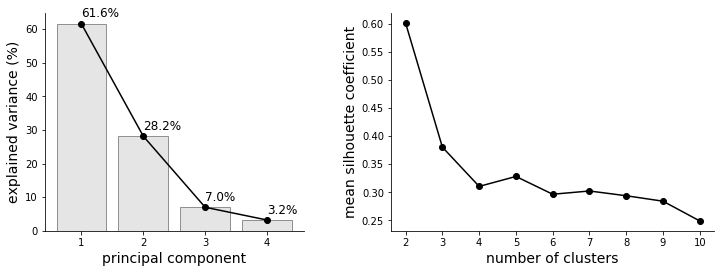

In [8]:
# pca supplementary plots (explained variance and silhouette scores for k clusters)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [0.4, 0.5], 'wspace': 0.3})

axes[0].bar(np.arange(4), pca.explained_variance_ratio_ * 100, facecolor=(0, 0, 0, 0.1), edgecolor=(0, 0, 0, 0.4))
axes[0].plot(pca.explained_variance_ratio_ * 100, 'ko-')

for x, ev in enumerate(pca.explained_variance_ratio_ * 100):
    axes[0].text(x, ev + 2, '{:.1f}%'.format(ev), fontsize=12)
    
axes[0].set_ylabel('explained variance (%)', fontsize=14)
axes[0].set_xticks(np.arange(4))
axes[0].set_xticklabels(np.arange(4) + 1)
axes[0].set_xlabel('principal component', fontsize=14)

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

silhouette_avg = []

for n_clusters in np.arange(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(social_space)

    silhouette_avg.append(silhouette_score(social_space, cluster_labels))

axes[1].plot(np.arange(2, 11), silhouette_avg, 'ko-')
axes[1].set_xlabel('number of clusters', fontsize=14)
axes[1].set_ylabel('mean silhouette coefficient', fontsize=14)

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')

plt.show()

In [9]:
# verify that cluster labels equal dom and sub labels
kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(social_space)
print(np.transpose([cluster_labels,
                    np.array(social_parameters['social_status'])]))

[[0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [0 'SUB']
 [1 'DOM']
 [1 'DOM']
 [1 'DOM']
 [1 'DOM']
 [1 'DOM']
 [1 'DOM']]


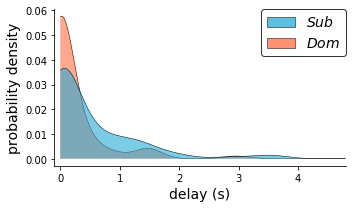

In [10]:
# delay time pdf plot
fig, ax = plt.subplots(figsize=(5, 3))

x_d = np.linspace(0, 120, 10000)
y_values = []
color_values = []

trial_dom_times = np.concatenate([dom_times for dom_times in dom_all_event_times])
sub_times = np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times]))
    
density = gaussian_kde(sub_times)(x_d)
y_values.append(density)
color_values.append(np.array(sub_color))

density = gaussian_kde(trial_dom_times)(x_d)
y_values.append(density)
color_values.append(np.array(dom_color))

y_values = np.array(y_values)
sort_idx = np.argsort(y_values.max(axis=1))[::-1]
y_values = y_values[sort_idx]
color_values = np.array(color_values)[sort_idx]

ax.fill_between([], [], facecolor=(*sub_color, 0.75), edgecolor=(0, 0, 0, 1), lw=0.5, label=r'$Sub$')
ax.fill_between([], [], facecolor=(*dom_color, 0.75), edgecolor=(0, 0, 0, 1), lw=0.5, label=r'$Dom$')

for idx, (y, c) in enumerate(zip(y_values, color_values)):
    ax.fill_between(x_d, y, alpha=0.6, facecolor=c, zorder=idx)
    ax.plot(x_d, y, alpha=1, lw=0.5, c='k', zorder=idx, solid_capstyle='butt')

ax.legend(edgecolor='k', fancybox=True, borderaxespad=0, fontsize=14, bbox_to_anchor=(1, 1), loc='upper right')

ax.set_xlim(-2.5, 120)
ax.set_xticks(np.arange(0, 125, 25))
ax.set_xticklabels(np.arange(0, 5))
ax.set_xlabel('delay (s)', fontsize=14)
ax.set_ylabel('probability density', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()

plt.show()

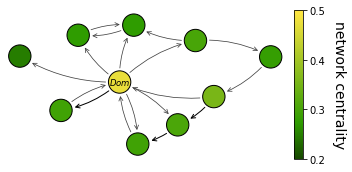

In [23]:
# example network visualization, rerun until good network layout
trial_idx = 4

tracks = load(trials[trial_idx][0])
event_ids = all_event_ids[trial_idx]
dom_id = trials[trial_idx][1]

centrality = get_social_influence(tracks, event_ids, dom_id, plot=False, plot_network=True)

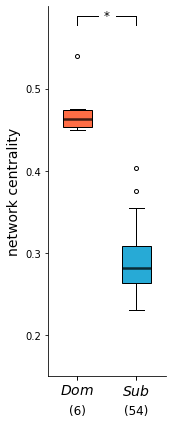

In [12]:
# network centrality boxplots
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = plt.boxplot([centrality_dom, centrality_sub],
                  widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                  medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                  patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

ax.set_ylim((0.15, 0.6))
ax.set_yticks(np.arange(0.2, 0.6, 0.1))
ax.set_ylabel('network centrality', fontsize=14)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(centrality_dom)),
                    r'$Sub$', '\n''({})'.format(len(centrality_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] - 1 * y_range * bracket_height

for x_values, idx in zip([[1, 1.35], [1.65, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 2, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

fig.tight_layout()

plt.show()

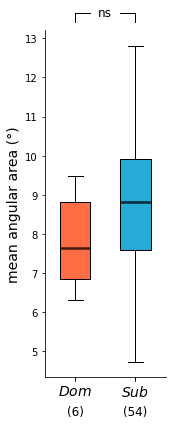

In [13]:
# angular area boxplots
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = ax.boxplot([aa_out_dom, aa_out_sub],
                 widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                 medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                 patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(aa_out_dom)),
                    r'$Sub$', '\n''({})'.format(len(aa_out_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.set_ylabel('mean angular area (°)', fontsize=14)

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] + 2 * y_range * bracket_height

for x_values, idx in zip([[1, 1.25], [1.75, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 1, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, 'ns', horizontalalignment='center', verticalalignment='center', size=12, color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.show()

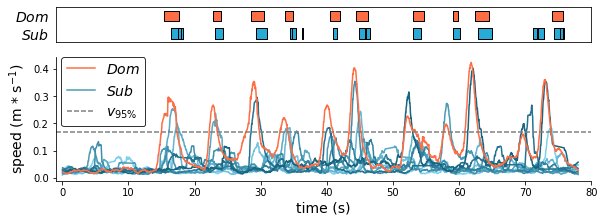

In [14]:
# speed event example plot
trial_idx = 2

tracks = load(trials[trial_idx][0])
dom_id = trials[trial_idx][1]
px_p_m = trials[trial_idx][2] / bottom_length
fps = trials[trial_idx][3]

speed_distribution = get_speed_distribution(tracks, fps)
q = np.quantile(speed_distribution, 0.95)
_ = threshold_speed(tracks, q=q, fps=fps, dom_id=dom_id,
                    plot=True,
                    xlim=(2*25*60, 3.3*25*60),
                    figsize=(8.5, 3.2),
                    xticks=np.arange(2*25*60, 3.3*25*60 + 250, 25*10),
                    xticklabels=np.arange(0, 100, 10),
                    ylabel=r'speed (m * s$^{-1}$)',
                    xlabel='time (s)',
                    q_label=r'$v_{95\%}$',
                    scale=px_p_m,
                    legend_bbox_to_anchor=(0.01, 1))

# Network randomization

In [15]:
# identical to main analysis, but pick dom id randomly between 0 and 9

angular_areas = load('../../data/visualfield/angular_areas_all_trials.pkl')
avg_centrality_dom = []
avg_centrality_sub = []
avg_pairwise_dist_dom = []
avg_pairwise_dist_sub = []
avg_aa_out_dom = []
avg_aa_out_sub = []
avg_rel_time_above_dom = []
avg_rel_time_above_sub = []
avg_initiator_count_dom = []
avg_initiator_count_sub = []

for trial_idx in range(len(trials)):

    tracks = load(trials[trial_idx][0])
    dom_id = trials[trial_idx][1]
    tracks, dom_id = enumerate_identities(tracks, dom_id)
    px_p_m = trials[trial_idx][2] / bottom_length
    fps = trials[trial_idx][3]
            
    speed_distribution = get_speed_distribution(tracks, fps)
    q = np.quantile(speed_distribution, 0.95)
    intervals_above = threshold_speed(tracks, q, fps, dom_id=None, plot=False)
    
    data = list(get_data(tracks, intervals_above, px_p_m))
    data[2] = angular_areas[trial_idx] # inject visual field data here
    
    for _ in range(1000):
        grouped_data = group_data(tracks, data, np.random.randint(10)) # with random dom id

        avg_centrality_dom.append(grouped_data[0][0])
        avg_centrality_sub.append(grouped_data[0][1])
        avg_pairwise_dist_dom.append(grouped_data[1][0])
        avg_pairwise_dist_sub.append(grouped_data[1][1])
        avg_aa_out_dom.append(grouped_data[2][0])
        avg_aa_out_sub.append(grouped_data[2][1])
        avg_rel_time_above_dom.append(grouped_data[3][0])
        avg_rel_time_above_sub.append(grouped_data[3][1])
        avg_initiator_count_dom.append(np.array([(grouped_data[-2][0] == 0).sum()]))
        avg_initiator_count_sub.append(np.array([(grouped_data[-2][1][idx] == 0).sum() \
                                                 for idx in range(9)]))

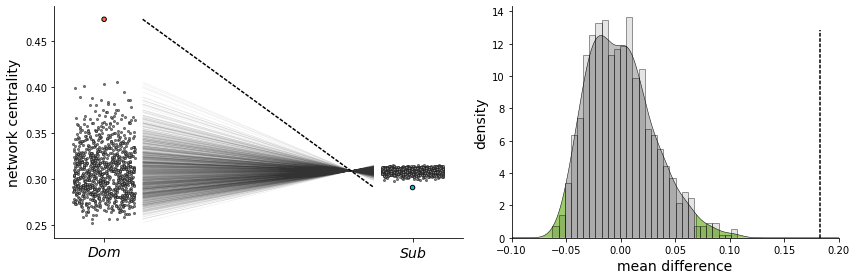

'p-value: -1.3766765505351941e-14'

In [16]:
# network randomization test for network centrality
plot_network_randomization(avg_metric_sub=avg_centrality_sub,
                           avg_metric_dom=avg_centrality_dom,
                           metric_sub=centrality_sub,
                           metric_dom=centrality_dom,
                           min_x_sub=0.15,
                           max_x_sub=0.6,
                           min_x_dom=0.15,
                           max_x_dom=0.6,
                           ylabel='network centrality',
                           xlim_hist=(-0.1, 0.2))

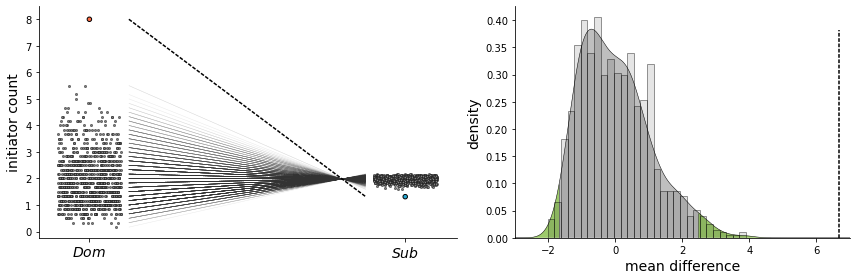

'p-value: 1.1324274851176597e-14'

In [17]:
# network randomization test for initiator count
initiator_count_dom = np.array([(event_times == 0).sum() for event_times in dom_all_event_times])
initiator_count_sub = np.array([(event_times == 0).sum() if event_times.size > 0 else 0 for event_times in np.concatenate(sub_all_event_times)])

plot_network_randomization(avg_metric_sub=avg_initiator_count_sub,
                           avg_metric_dom=avg_initiator_count_dom,
                           metric_sub=initiator_count_sub,
                           metric_dom=initiator_count_dom,
                           min_x_sub=0.0,
                           max_x_sub=10.0,
                           min_x_dom=0.0,
                           max_x_dom=10.0,
                           ylabel='initiator count',
                           xlim_hist=(-3, 7))

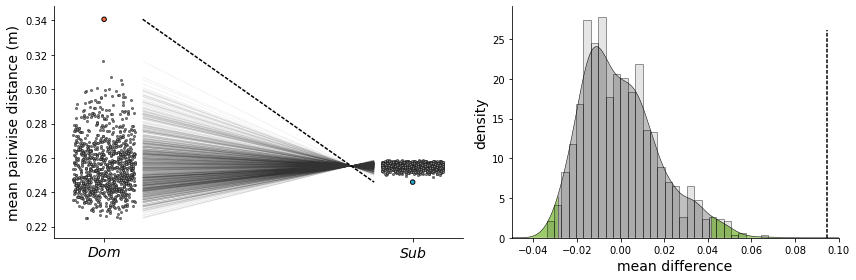

'p-value: 4.922728891187944e-13'

In [18]:
# network randomization test for mean pairwise distance
plot_network_randomization(avg_metric_sub=avg_pairwise_dist_sub,
                           avg_metric_dom=avg_pairwise_dist_dom,
                           metric_sub=pairwise_dist_sub,
                           metric_dom=pairwise_dist_dom,
                           min_x_sub=0.05,
                           max_x_sub=0.55,
                           min_x_dom=0.05,
                           max_x_dom=0.55,
                           ylabel='mean pairwise distance (m)',
                           xlim_hist=(-0.05, 0.1))

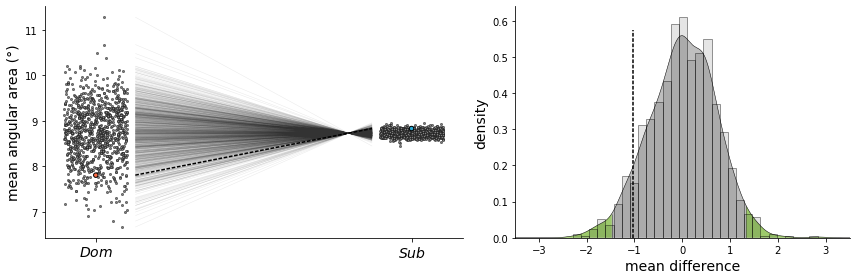

'p-value: 0.17198790375627213'

In [19]:
# network randomization test for mean angular area
plot_network_randomization(avg_metric_sub=avg_aa_out_sub,
                           avg_metric_dom=avg_aa_out_dom,
                           metric_sub=aa_out_sub,
                           metric_dom=aa_out_dom,
                           min_x_sub=2,
                           max_x_sub=16,
                           min_x_dom=2,
                           max_x_dom=16,
                           ylabel='mean angular area (°)',
                           xlim_hist=(-3.5, 3.5))

# Track coverage and export

In [20]:
coverage_cleaned = []
coverage_initial = []
identified = []

for trial_idx in range(len(trials)):
    tracks = load(trials[trial_idx][0])
    pooled = tracks_to_pooled(tracks)
    # detection count divided by theoretical detection count for 10 individuals
    coverage_cleaned.append(pooled['FRAME_IDX'].size / (pooled['FRAME_IDX'].max() * 10))
    tracks = load(trials[trial_idx][0].replace('_cleaned', ''))
    pooled = tracks_to_pooled(tracks)
    coverage_initial.append(pooled['FRAME_IDX'].size / (pooled['FRAME_IDX'].max() * 10))
    identified.append(tracks['IDENTITIES'].size)
    
print('initial coverage:', np.mean(coverage_initial))
print('average losses:', np.mean(identified) / 10)
print('false predictions:', 1 - np.mean(coverage_cleaned) / np.mean(coverage_initial))
print('processed coverage:', np.mean(coverage_cleaned))

with h5py.File('../../data/mask_rcnn/dataset.h5', 'r') as annotations:
    annotated = annotations['annotations'][:]
print('annotated frames:')
print(np.array(annotated).astype(np.str))
print('number of annotations:', len(annotated))

initial coverage: 0.947767029639086
average losses: 1.0
false predictions: 0.0
processed coverage: 0.947767029639086
annotated frames:
['T3.mp4/0' 'T3.mp4/1098' 'T3.mp4/1717' 'T3.mp4/1901' 'T3.mp4/2434'
 'T3.mp4/257' 'T3.mp4/2924' 'T3.mp4/3092' 'T3.mp4/3380' 'T3.mp4/3805'
 'T3.mp4/4068' 'T3.mp4/584' 'T3.mp4/840' 'T4.mp4/1219' 'T4.mp4/1942'
 'T4.mp4/241' 'T4.mp4/3494' 'T4.mp4/4376' 'T4.mp4/5432' 'T4.mp4/7032'
 'T5.mp4/4068' 'T5.mp4/4954' 'T5.mp4/653' 'T5.mp4/6661' 'T5.mp4/7319'
 'T5.mp4/7434' 'T5.mp4/7435' 'T5.mp4/7449' 'T6.mp4/1768' 'T6.mp4/4172'
 'T6.mp4/6220' 'T6.mp4/7162' 'T6.mp4/7331' 'T6.mp4/87']
number of annotations: 34


In [21]:
for tracks_file in glob('../../data/tracks/revised/*cleaned.pkl'):
    tracks = load(tracks_file)
    for i in tracks['IDENTITIES']:
        tracks[str(i)]['X'] = tracks[str(i)]['SPINE'][:, 1, 1]
        tracks[str(i)]['Y'] = tracks[str(i)]['SPINE'][:, 1, 0]
        for key in [key for key in tracks[str(i)]]:
            if key not in ['FRAME_IDX', 'X', 'Y']:
                tracks[str(i)].pop(key)
    pooled = tracks_to_pooled(tracks)
#     pd.DataFrame(pooled).to_csv(tracks_file.replace('_revised.pkl', '.csv')) # export to csv